## VaR Portfolio Blue
### The use of Var to determine the share of assets
#### 13.04.2019

In [130]:
# connection necessary packeges
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data
from scipy import stats
import scipy.optimize as sco
import scipy.interpolate as sci
import matplotlib.pyplot as plt
import datetime as dt
from urllib.request import urlopen
import sklearn.linear_model as lm
import statsmodels.api as sm

## Helpfull function

In [83]:
# profitability of the portfolio
def port_mean(d, means, n_days=250):
    d = np.array(d)
    return np.sum(means * d) * n_days

# max profitability
def max_port_mean(d, means, n_days=250):
    d = np.array(d)
    return -np.sum(means * d) * n_days


# volatility of the portfolio
def port_vol(d, cov, n_days=250):
    d = np.array(d)
    return np.sqrt(np.dot(d.T, np.dot(cov * n_days, d)))


# Variation of the portfolio
def port_varianced(d, cov, n_days=250):
    d = np.array(d)
    return np.dot(d.T, np.dot(cov * n_days, d))


# Sharpe ratio 
def Sharpe_ratio(weights, cov, means, r_f, n_days=250):
    weights = np.array(weights)
    mean = np.sum(means * weights) * n_days
    vol = np.sqrt(np.dot(weights.T, np.dot(cov * n_days, weights)))
    return -((mean-r_f)/vol)


# Vallue at Risk (VaR) of asset
def asset_VaR(df, alpha = 5):
    var = []
    col = list(df.columns)
    for i in col:
        num = sorted(list(df[i]))
        var.append(-np.percentile(num, 5))
    return var


# Portfolio Value at Risk 
def port_VaR(weights, var):
    a = np.array(weights)
    b = np.array(var)
    return np.dot(a, b)


# convert Date from Finam
def conv_finam(df):
    df.columns = ['Ticer', 'Per', 'Date', 'Time', 'Close']
    for i in list(df.index):
        temp = str(df.iloc[i, 2])
        temp = temp[6:8] + '.' + temp[4:6] + '.' + temp[0:4] 
        df.iloc[i, 2] = temp
        df.iloc[i, 2] = pd.to_datetime(df.iloc[i, 2], format='%d.%m.%Y')
        df.iloc[i, 2] = df.iloc[i, 2].date()

In [28]:
# MOEXBC
names = ['ALRS', 'CHMF', 'FIVE', 'GAZP', 'GMKN', 'LKOH', 'MGNT', 'MTSS', 'NVTK', 'ROSN', 'SBER', 'SNGS', 'TATN', 'VTBR', 'YNDX']
# All ticker from finam
ticker = pd.read_csv('https://raw.githubusercontent.com/Aurilino/Diploma/master/MAIN_DATA/finam_list.csv', sep=';')
# used ticker
ticker = ticker[ticker['Tiker'].isin(names)]
name = list(ticker['Tiker'])
code = list(ticker['code'])
n_assets = len(names)

In [29]:
date_from = '01.01.2014'
date_to = '01.01.2019'
day_from = date_from[:2]; mon_from = date_from[3:5]; year_from = date_from[6:10]
day_to = date_to[:2]; mon_to = date_to[3:5]; year_to = date_to[6:10]
workdate_from = year_from[2:] + mon_from + day_from
workdate_to = year_to[2:] + mon_to + day_to
work = dict()
means = []
vols = []
var = []
for i in range(len(name)):
    N = name[i]
    C = str(code[i])
    url = str('http://export.finam.ru/' + N + '_' + workdate_from + '_' +  workdate_to + '.csv' +  
          '?market=1&em=' + C + '&code=' + N + '&apply=0&df=' + str(int(day_from)) + '&mf=' + 
          str(int(mon_from) - 1) + '&yf=' + year_from + '&from=' + date_from + '&dt=' + 
          str(int(day_to)) + '&mt=' + str(int(mon_to) - 1) + '&yt=' + year_to + '&to=' + 
          date_to + '&p=8&f=' + N + '_' + workdate_from + '_' +  workdate_to + '&e=.csv&cn=' + N + 
          '&dtf=1&tmf=1&MSOR=1&mstime=on&mstimever=1&sep=1&sep2=1&datf=4&at=1')
    df = pd.read_csv(url)
    conv_finam(df)
    chart = [np.log(list(df['Close'])[j]) - np.log(list(df['Close'])[j-1]) for j in range(1, len(list(df['Date'])))]
    means.append(np.mean(chart))
    vols.append(np.std(chart))
    var.append(-np.percentile(sorted(chart), 5))
    df.index = df['Date']
    df = pd.DataFrame(df.loc[:, 'Close'])
    df.columns = [N]
    if i == 0:
        main = df
    else:
        main = pd.merge(main, df, left_index=True, right_index=True)
main.columns = names
summary = pd.DataFrame(dict(Ticker = names, Return = means, Risk = vols, VaR = var))
summary.index = summary['Ticker']
summary = summary.iloc[:, 1:]

In [30]:
main.head()

,ALRS,CHMF,FIVE,GAZP,GMKN,LKOH,MGNT,MTSS,NVTK,ROSN,SBER,SNGS,TATN,VTBR,YNDX
Date,,,,,,,,,,,,,,,
2018-02-01,82.13,941.8,2110.0,145.39,11639.0,3760.5,5219.0,311.50,732.0,344.95,263.20,29.260,578.65,0.04938,2202.0
2018-02-02,81.81,918.0,2052.0,144.00,11496.0,3797.0,5032.0,304.40,733.0,339.90,257.32,28.955,579.00,0.04920,2150.0
2018-02-05,83.00,923.8,2089.5,144.53,11581.0,3752.0,4950.0,304.55,728.0,338.30,255.64,29.550,564.40,0.04908,2150.0
2018-02-06,81.20,912.9,2070.0,141.59,11308.0,3655.5,4785.0,302.75,729.7,330.00,258.94,28.605,542.70,0.04702,2054.5
2018-02-07,84.00,932.2,2090.0,141.00,11268.0,3735.0,4725.0,301.00,736.4,336.00,257.58,29.415,563.10,0.04761,2140.5


In [48]:
summary

,Return,Risk,VaR
Ticker,,,
ALRS,0.000855,0.020366,0.031990
CHMF,0.000890,0.018758,0.027513
FIVE,-0.000857,0.023666,0.039931
GAZP,0.000100,0.015407,0.022932
GMKN,0.000719,0.018542,0.026908
LKOH,0.000732,0.016209,0.025949
MGNT,-0.000744,0.020665,0.033584
MTSS,-0.000225,0.019630,0.028121
NVTK,0.000841,0.018504,0.026871


In [32]:
# get daily returns
main = main.apply(lambda x: np.log(x)-np.log(x).shift(1))
main.dropna(inplace = True)
main.head()

,ALRS,CHMF,FIVE,GAZP,GMKN,LKOH,MGNT,MTSS,NVTK,ROSN,SBER,SNGS,TATN,VTBR,YNDX
Date,,,,,,,,,,,,,,,
2018-02-02,-0.003904,-0.025596,-0.027873,-0.009606,-0.012362,0.009659,-0.036488,-0.023057,0.001365,-0.014748,-0.022594,-0.010478,0.000605,-0.003652,-0.023898
2018-02-05,0.014441,0.006298,0.018110,0.003674,0.007367,-0.011922,-0.016430,0.000493,-0.006845,-0.004718,-0.006550,0.020341,-0.025539,-0.002442,0.000000
2018-02-06,-0.021925,-0.011869,-0.009376,-0.020552,-0.023855,-0.026056,-0.033902,-0.005928,0.002332,-0.024840,0.012826,-0.032502,-0.039207,-0.042879,-0.045435
2018-02-07,0.033902,0.020921,0.009615,-0.004176,-0.003544,0.021515,-0.012618,-0.005797,0.009140,0.018019,-0.005266,0.027923,0.036901,0.012470,0.041007
2018-02-08,0.028171,-0.015568,0.020834,-0.027320,-0.014121,-0.013206,0.020943,-0.017596,-0.007360,-0.028222,-0.017190,-0.018702,-0.013589,-0.002103,0.008606


In [33]:
MOEXBC = pd.read_csv('https://raw.githubusercontent.com/Aurilino/Diploma/master/MAIN_DATA/MOEXBC.csv',
                     header=0, index_col=0, parse_dates={'Date': [0]}, sep=';')
MOEXBC = pd.DataFrame(MOEXBC.iloc[:, 3])
MOEXBC = MOEXBC.apply(lambda x: np.log(x)-np.log(x).shift(1))
MOEXBC.dropna(inplace = True)
MOEXBC.head()

,CLOSE
Date,
2012-04-01,0.003123
2012-05-01,-0.007830
2012-06-01,0.003333
2012-09-01,0.003625
2012-10-01,0.021838


In [36]:
# Covariance matrix
cov = np.cov(main, rowvar=False)

In [34]:
print('Daily return of MOEXBC: ', round(np.mean(list(MOEXBC['CLOSE'])), 4) * 100, '%', sep='')
print('Daily risk of MOEXBC: ', round(np.std(list(MOEXBC['CLOSE'])), 4) * 100, '%', sep='')
print('Daily VaR of MOEXBC with alpha 95%: ', round(-np.percentile(list(MOEXBC['CLOSE']), 5), 4) *100, '%', sep='')

Daily return of MOEXBC: 0.05%
Daily risk of MOEXBC: 1.18%
Daily VaR of MOEXBC with alpha 95%: 1.73%


## Sigma portfolio

In [90]:
# restriction - the sum of weights should not exceed one
cons=({'type':'eq','fun':lambda x:sum(x)-1})
# portfolio with equal weights on all assets
w_initial = n_assets*[1./n_assets]
# the restriction weights of the assets
bnds = tuple((0, 1) for x in range(n_assets))
# find maximum and minimum profitability
min_ret = sco.minimize(port_mean, w_initial, (means), method = 'SLSQP', bounds = bnds, constraints = cons)
max_ret = sco.minimize(max_port_mean, w_initial, (means), method = 'SLSQP', bounds = bnds, constraints = cons)

In [91]:
# the minimum and maximum portfolio returns
min_ret = min_ret['fun']
max_ret = -max_ret['fun']

In [92]:
# create an array of returns 
lrets = np.linspace(min_ret,max_ret,100)
# portfolio with minimum variance
min_vari = sco.minimize(port_varianced, w_initial, (cov), method = 'SLSQP', bounds = bnds, constraints = cons)
# portfolio with minimum vallue at risk
min_var = sco.minimize(port_VaR, w_initial, (var), method = 'SLSQP', bounds = bnds, constraints = cons)

### Minimum variation portfolion

In [79]:
dt = pd.DataFrame(dict(Tiket = names, Weights = list(min_vari['x'])))
print(port_mean(list(dt['Weights']), means) / 252 * 100)
print(port_vol(list(dt['Weights']), cov) / np.sqrt(252) * 100)
print(port_VaR(list(dt['Weights']), var))

0.010562509147088527
0.9075579321679154
0.027371538775794266


### Minimum VaR portfolion

In [80]:
dt = pd.DataFrame(dict(Tiket = names, Weights = list(min_var['x'])))
print(port_mean(list(dt['Weights']), means) / 252 * 100)
print(port_vol(list(dt['Weights']), cov) / np.sqrt(252) * 100)
print(port_VaR(list(dt['Weights']), var))

0.009902592332916035
1.5436374183928327
0.022931883221123977


In [59]:
blue_weights = [str(round(i * 100, 4)) + '%' for i in [0.0276, 0.0208, 0.0218, 0.1482, 0.0736, 0.2047, 0.0338, 0.0276, 0.07, 0.0554,
                 0.172, 0.0272, 0.0631, 0.0148, 0.0394]]
minvol_weights = [str(round(i * 100, 4)) + '%' for i in list(min_vari['x'])]
minvar_weights = [str(round(i * 100, 4)) + '%' for i in list(min_var['x'])]
df = pd.DataFrame(dict(Tiket = names, Blue = blue_weights, Min_vol = minvol_weights, Min_VaR = minvar_weights))
df

,Tiket,Blue,Min_vol,Min_VaR
0,ALRS,2.76%,8.4683%,0.0%
1,CHMF,2.08%,9.244%,0.0%
2,FIVE,2.18%,0.0%,0.0%
3,GAZP,14.82%,0.0%,100.0%
4,GMKN,7.36%,0.0%,0.0%
5,LKOH,20.47%,0.0%,0.0%
6,MGNT,3.38%,11.7082%,0.0%
7,MTSS,2.76%,9.7611%,0.0%
8,NVTK,7.0%,2.9519%,0.0%
9,ROSN,5.54%,10.4668%,0.0%


## Effective boundary with the use of VaR

In [122]:
# create an array of VaRs
lvar = []
lvol = []
# for each value of profitability, we find the portfolio with minimum volatility
for ret in lrets:
    cons = ({'type':'eq', 'fun':lambda x: sum(x)-1}, {'type':'eq', 'fun':lambda x: port_mean(x, means) - ret})
    res = sco.minimize(port_VaR, w_initial, (var), method = 'SLSQP', bounds = bnds, constraints = cons)
    x = port_vol(list(res['x']), cov)
    lvol.append(x)
    lvar.append(res['fun'])
# an array of the volatility of the efficient frontier
lvar = np.array(lvar)
lvol = np.array(lvol)
# risk free rate
r_f = 0.075

In [100]:
print(min(lrets))
print(max(lrets))

-0.2142953617018367
0.25924680685234824


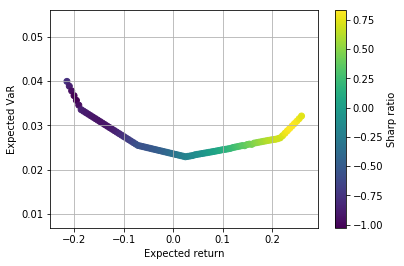

In [98]:
# _=plt.figure(figsize = (15, 10))
_=plt.scatter(lrets, lvar, c = (lrets-r_f) / lvol, marker = 'o')
_=plt.grid(True)
_=plt.xlabel('Expected return')
_=plt.ylabel('Expected VaR')
_=plt.colorbar(label='Sharp ratio')

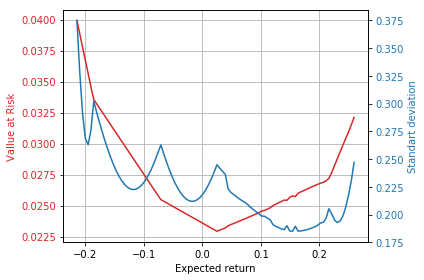

In [99]:
_=fig, ax1 = plt.subplots()
_=plt.grid(True)
_=color = 'tab:red'
_=ax1.set_xlabel('Expected return')
_=ax1.set_ylabel('Vallue at Risk', color=color)
_=ax1.plot(lrets, lvar, color=color)
_=ax1.tick_params(axis='y', labelcolor=color)
_=ax2 = ax1.twinx()  
_=color = 'tab:blue'
_=ax2.set_ylabel('Standart deviation', color=color)  
_=ax2.plot(lrets, lvol, color=color)
_=ax2.tick_params(axis='y', labelcolor=color)
_=fig.tight_layout()  

In [103]:
group = [lvar[i] - lvol[i] for i in range(len(lvol))]

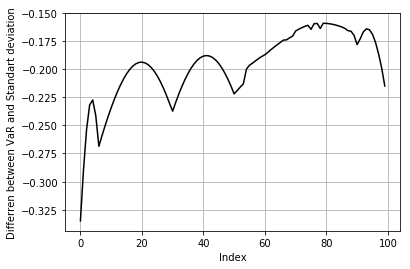

In [108]:
# _=plt.figure(figsize = (15, 10))
_=plt.plot(range(len(lvol)), group, c = 'black', marker = '')
_=plt.grid(True)
_=plt.xlabel('Index')
_=plt.ylabel('Differren between VaR and Standart deviation')

## Regression between VaR and Sigma

In [133]:
x = lvar.reshape(-1, 1)
y = lvol.reshape(-1, 1)

x2 = sm.add_constant(x)
est = sm.OLS(y, x2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     73.18
Date:                Wed, 17 Apr 2019   Prob (F-statistic):           1.64e-13
Time:                        20:57:14   Log-Likelihood:                 226.69
No. Observations:                 100   AIC:                            -449.4
Df Residuals:                      98   BIC:                            -444.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0685      0.018      3.730      0.0